## Código

### Bibliotecas

In [11]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.io.wavfile import write

from scipy.io import wavfile

from sklearn.metrics import mean_squared_error

from prettytable import PrettyTable

### Abertura de arquivo .wav

In [12]:
class Wave_analysis:
    def __init__(self, file_name=None, N=4096):        
        self.data = None
        self.N = N
        self.sample_rate = None
        self.noise_signal = None
        self.cutoff = 0

        if file_name:
            self.open_file(file_name)

    def open_file(self, file_name):
        """ Abertura de arquivo .wav """
        self.sample_rate, self.data = wavfile.read(file_name)
        return self.sample_rate, self.data

    def preprocessing(self):
        """ Pré processamento do sinal: mono + normalização """

        if len(self.data.shape) == 2:

            self.data = self.data[:, 0]

        self.data = self.data / np.max(np.abs(self.data))

        self.data = self.data[:self.N]

        return self.data

    def fft(self, signal=None):
        """ 
        Transformada de Fourier.
        Saídas:
            freq: vetor de frequências correspondentes
            spectrum: espectro do sinal 
        """
        if signal is None:
            signal = self.data

        signal = signal[:self.N] if len(signal) >= self.N else signal
        freq = np.fft.fftfreq(self.N, d=1/self.sample_rate)

        spectrum = np.fft.fft(signal)

        return freq, spectrum

    def white_noise(self):
        """ Adiciona um ruído branco ao sinal. """

        ruido = 0.4 * np.random.normal(0, 1, self.N)

        self.noise_signal = self.data[:self.N] + ruido

        return self.noise_signal
    
    def low_pass_filter(self, cutoff):
        """ 
        Filtro passa-baixa para diminuição de ruído no sinal. 
            data: sinal com ruído.
            cutoff: frequência de corte do filtro.
            sample_rate: taxa de amostragem.
        """
        self.cutoff = cutoff
        freq, spectrum = self.fft(self.noise_signal)
        filtered_signal = np.fft.ifft(spectrum * (np.abs(freq) <= self.cutoff)).real
        return filtered_signal

## Visualizando os sinais

- Visualizar as ondas dos sinais no domínio do tempo
- Visualizar o espectro dos sinais

In [13]:
# Abrindo os arquivos .wav e definindo a amostra do sinal
wave_pure = Wave_analysis(file_name="aquivos wav/flautaC.wav")
wave_noise = Wave_analysis(file_name="aquivos wav/people-talking-with-microphone-man-voice.wav")
wave_environment = Wave_analysis(file_name="aquivos wav/naiwasha_lake_slum_ambient_kenya.wav")

# Preprocessando os sinais
signal_pure = wave_pure.preprocessing()
signal_noise = wave_noise.preprocessing()
signal_environment = wave_environment.preprocessing()

# Salvando a frequência e o espectro dos sinais
freq_pure, spectrum_pure = wave_pure.fft()
freq_noise, spectrum_noise = wave_noise.fft()
freq_environment, spectrum_environment = wave_environment.fft()


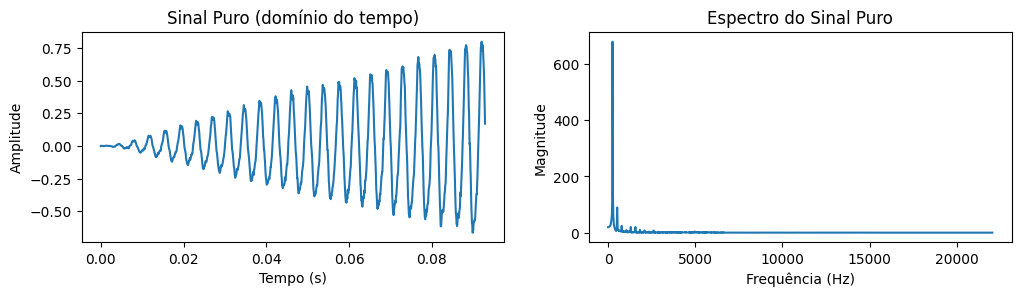

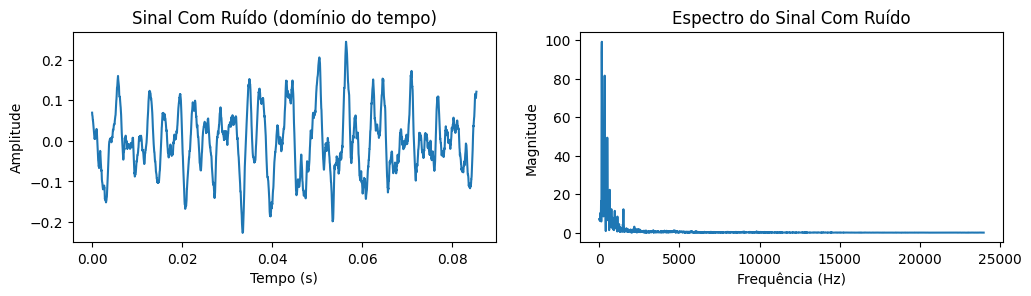

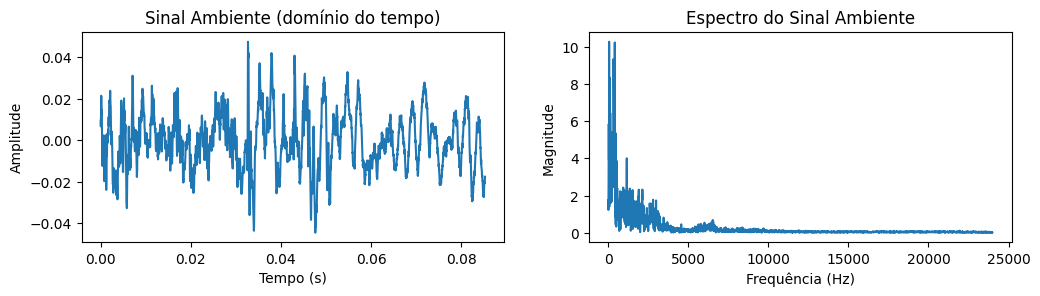

In [14]:
# Salvando o tempo e a amplitude de cada sinal
t_pure = np.arange(wave_pure.N) / wave_pure.sample_rate
N_pure = wave_pure.N

t_noise = np.arange(wave_noise.N) / wave_noise.sample_rate
N_noise = wave_noise.N

t_environment = np.arange(wave_environment.N) / wave_environment.sample_rate
N_environment = wave_environment.N

# Plotando os sinais
titles = ['Puro', 'Com Ruído', 'Ambiente']
ts = [t_pure, t_noise, t_environment]
Ns = [N_pure, N_noise, N_environment]
signals = [signal_pure, signal_noise, signal_environment]
freqs = [freq_pure, freq_noise, freq_environment]
spectruns = [spectrum_pure, spectrum_noise, spectrum_environment]

for title, t, N, signal, freq, spectrum in zip(titles, ts, Ns, signals, freqs, spectruns):
    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.plot(t, signal)
    plt.title(f"Sinal {title} (domínio do tempo)")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")

    plt.subplot(2,2,2)
    plt.plot(freq[:N//2], np.abs(spectrum)[:N//2])
    plt.title(f"Espectro do Sinal {title}")
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Magnitude")

    plt.show()

## Adicionando ruído artificial ao sinal "flautaC.wav"

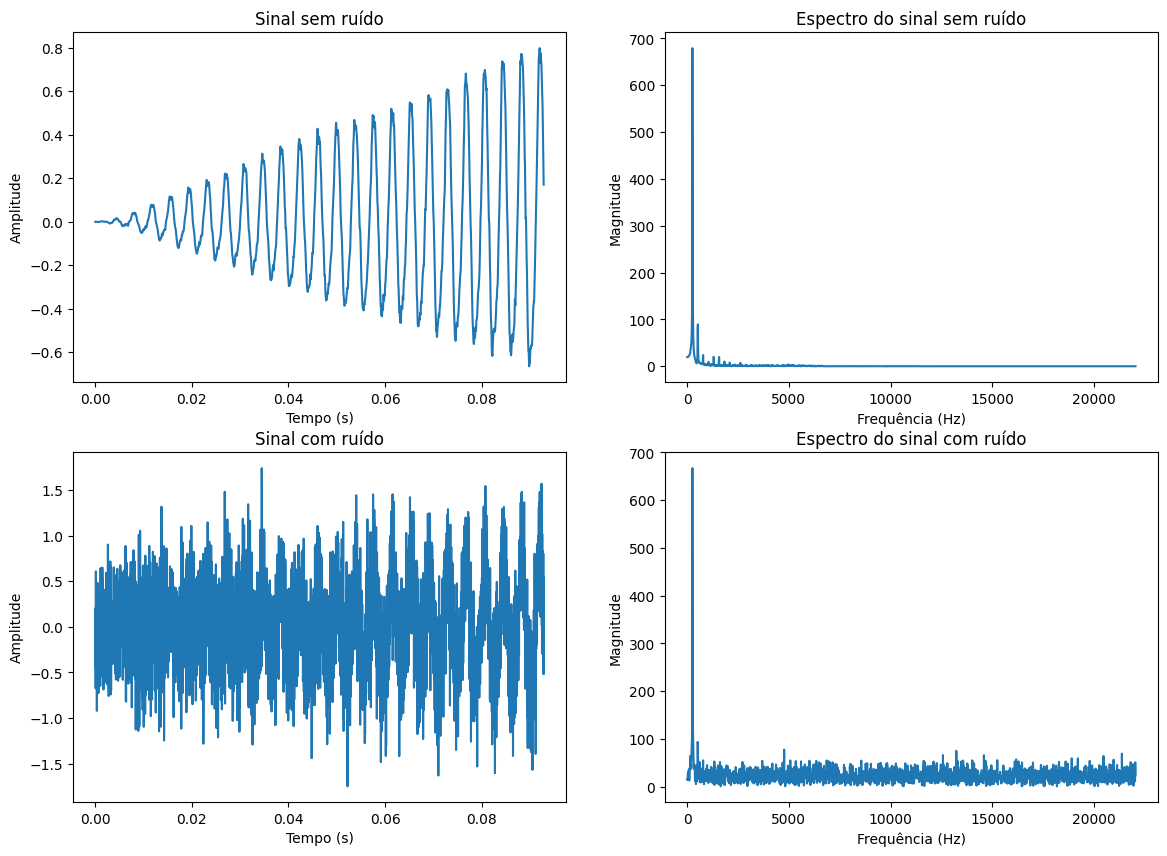

In [15]:
signal_pure_noise = wave_pure.white_noise()

freq_pure_noise, spectrum_pure_noise = wave_pure.fft(wave_pure.noise_signal)

plt.figure(figsize=(14, 10))
plt.subplot(2,2,1)
plt.plot(t_pure, signal_pure)
plt.title("Sinal sem ruído")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(2,2,2)
plt.plot(freq_pure[:N//2], np.abs(spectrum_pure)[:N//2])
plt.title("Espectro do sinal sem ruído")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")

plt.subplot(2,2,3)
plt.plot(t_pure, signal_pure_noise)
plt.title("Sinal com ruído")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(2,2,4)
plt.plot(freq_pure_noise[:N//2], np.abs(spectrum_pure_noise)[:N//2])
plt.title("Espectro do sinal com ruído")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")

plt.show()

## Aplicando Filtro Passa-Baixa para recuperar o sinal

Para encontrarmos a melhor faixa de corte para o filtro Passa-baixa será utilizado a média do erro quadrático (MSE). De acordo com o MSE é possivel visualizar a melhor faixa de corte, quanto menor o mse mais próximo ao sinal original.

In [16]:
# Faixas de cortes para teste
cutoffs = [500, 800, 1000, 1200, 1800, 2000]

# Lista para guardar os valores mse encontrados
mse_list = []

# Teste das faixas de corte
for cutoff in cutoffs:
    filtered_signal = wave_pure.low_pass_filter(cutoff)
    mse = mean_squared_error(signal_pure, filtered_signal)
    mse_list.append(mse)

# Melhor faixa de corte para o filtro
best_index = np.argmin(mse_list)
best_cutoff = cutoffs[best_index]

# Tabela para visualização dos resultados
table = PrettyTable()

table.field_names = ["Cutoff (Hz)", "Error quadrático médio"]
for mse, cutoff in zip(mse_list, cutoffs):
    mse = round(mse, 5)
    table.add_row([cutoff, mse])

table.add_row(["Melhor Cutoff", best_cutoff])
print(table)

+---------------+------------------------+
|  Cutoff (Hz)  | Error quadrático médio |
+---------------+------------------------+
|      500      |        0.00594         |
|      800      |         0.0056         |
|      1000     |        0.00721         |
|      1200     |        0.00852         |
|      1800     |        0.01246         |
|      2000     |         0.0142         |
| Melhor Cutoff |          800           |
+---------------+------------------------+


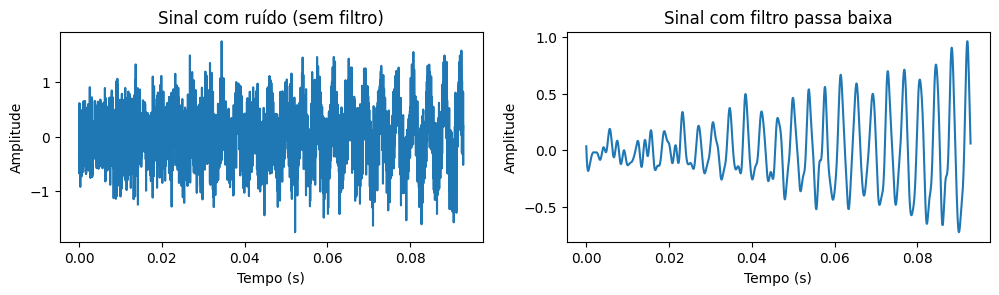

In [17]:
# Aplicacação do filtro com o melhor corte
filtered_signal = wave_pure.low_pass_filter(best_cutoff)

plt.figure(figsize=(12,6))

plt.subplot(2, 2, 1)

plt.plot(t_pure, signal_pure_noise)

plt.title("Sinal com ruído (sem filtro)")

plt.xlabel("Tempo (s)")

plt.ylabel("Amplitude")

plt.subplot(2, 2, 2)

plt.plot(t_pure, filtered_signal)

plt.title("Sinal com filtro passa baixa")

plt.xlabel("Tempo (s)")

plt.ylabel("Amplitude")

plt.show()

## Gerando os arquivos .wav para comparação

In [18]:
# --- Normalizando os sinais antes de salvar ---
def to_int16(signal):
    signal = signal / np.max(np.abs(signal))  # normaliza para [-1, 1]
    return np.int16(signal * 32767)

# Convertendo os sinais
pure_noise_int16 = to_int16(signal_pure_noise)
filtered_signal_int16 = to_int16(filtered_signal)

# Salvando os arquivos .wav
write("sinal_com_ruido.wav", wave_pure.sample_rate, pure_noise_int16)
write("sinal_filtrado.wav", wave_pure.sample_rate, filtered_signal_int16)


## Comparando visualmente e numericamente os efeitos do ruído e da filtragem

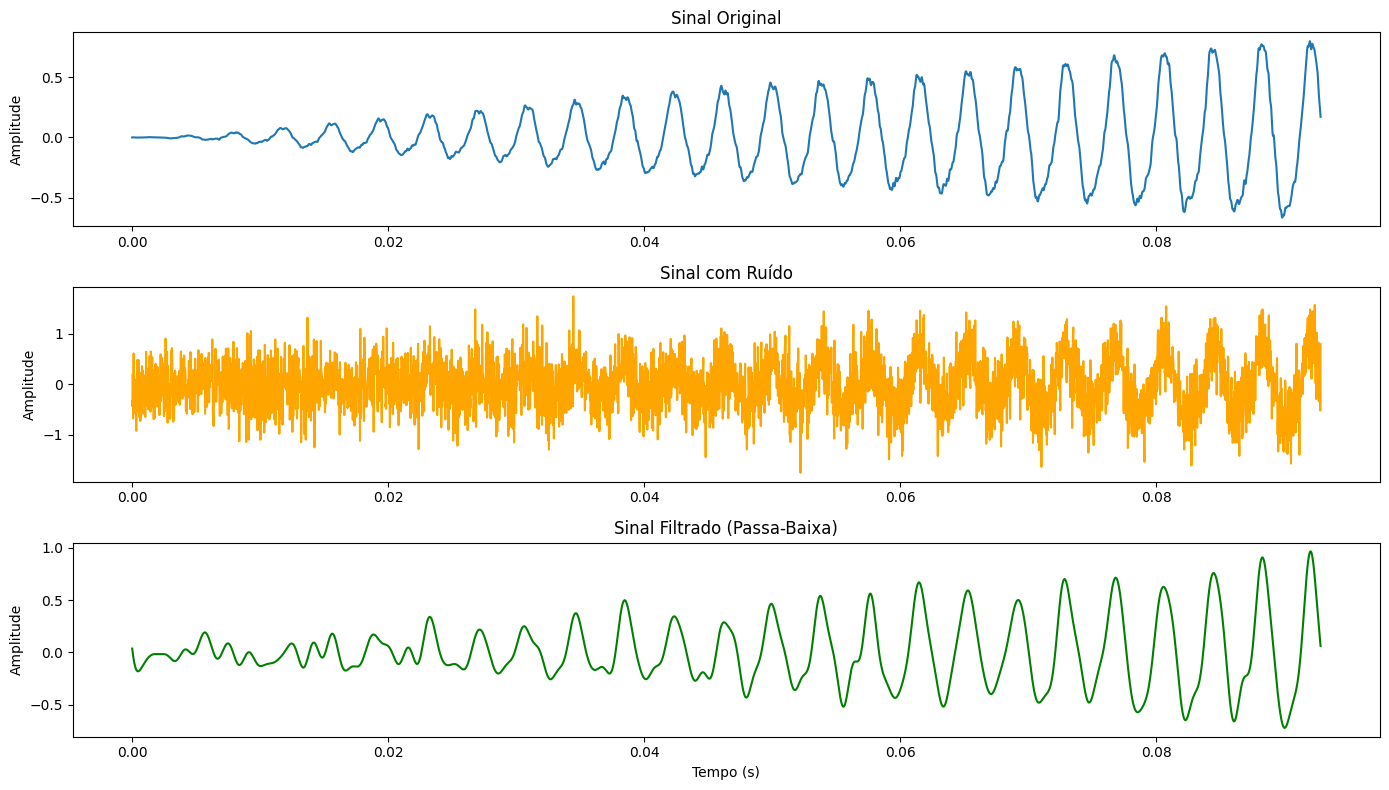

In [19]:
# Visualização dos sinais

plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(t_pure, signal_pure, label="Original")
plt.title("Sinal Original")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.plot(t_pure, signal_pure_noise, label="Com Ruído", color='orange')
plt.title("Sinal com Ruído")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.plot(t_pure, filtered_signal, label="Filtrado", color='green')
plt.title("Sinal Filtrado (Passa-Baixa)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


Para fazer a comparação númerica utilizaremos como critério a Relação Sinal-Ruído (SNR), onde é preciso dividir a Potência do sinal pela potência do ruído, se em unidade de potência bruta

$  SNR = \frac{Psignal}{Pnoise} $

Em decibéis é necessário fazer o log na base 10:

$ SNR (dB) = 10 \log_{10} (\frac{Psignal}{Pnoise}) $

Se os dois sinais estiverem em decibéis é necessário apenas fazer a diferença entre Sinal e ruído.

A partir do resultado do SNR podemos classificar se o está próximo ao original, se o SNR aumentar após o uso do filtro então o filtro conseguiu atenua o ruído, uma vez que quanto maior o SNR mais próximo o sinal está do original.

In [20]:
# Cálculo do SNR para sinais Continuos 

def snr(signal_original, signal_modified, fs):
    dt = 1 / fs
    T = len(signal_original) * dt
    signal_power = np.sum(signal_original**2) * dt # Em sinais contínuos a potência é calculado de forma diferente
    noise_power = np.sum((signal_original - signal_modified)**2) * dt

    snr = 10 * np.log10(signal_power / noise_power)

    return snr

fs = wave_pure.sample_rate

snr_noise = snr(signal_pure, signal_pure_noise, fs)
snr_filtered = snr(signal_pure, filtered_signal,fs)

print(f"SNR com ruído: {snr_noise:.2f} dB")
print(f"SNR após filtro: {snr_filtered:.2f} dB")

SNR com ruído: -2.71 dB
SNR após filtro: 11.96 dB


## Referências 

Filtro passa-baixa: https://www.youtube.com/watch?v=k716SBiBWcE

SNR: https://www-techtarget-com.translate.goog/searchnetworking/definition/signal-to-noise-ratio?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc

áudios: https://freesound.org